# TCNN Classifier

In [37]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import sys
import numpy as np
import random
from sklearn.metrics import accuracy_score

sys.path.append('../scripts')
import ml_helper as mlh
import ml_evaluation as mle
import Tcnn as tcnn
from Tcnn import TemporalConvNet
import Baseline_classifiers as bc

In [38]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
data_path = '../data'

Code inspiered:

https://de.mathworks.com/help/deeplearning/ug/sequence-to-sequence-classification-using-1-d-convolutions.html

References:

- [1] Bai, Shaojie, J. Zico Kolter, and Vladlen Koltun. “An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling.” Preprint, submitted April 19, 2018. https://arxiv.org/abs/1803.01271.

- [2] Oord, Aaron van den, Sander Dieleman, Heiga Zen, Karen Simonyan, Oriol Vinyals, Alex Graves, Nal Kalchbrenner, Andrew Senior, and Koray Kavukcuoglu. “WaveNet: A Generative Model for Raw Audio.” Preprint, submitted September 12, 2016. https://arxiv.org/abs/1609.03499.

- [3] Tompson, Jonathan, Ross Goroshin, Arjun Jain, Yann LeCun, and Christoph Bregler. “Efficient Object Localization Using Convolutional Networks.” 2015 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 648–56. https://doi.org/10.1109/CVPR.2015.7298664.


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [41]:
SEED = 42
def set_seed(SEED=SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
set_seed()

### Data Preparation

In [42]:
# Data preparation
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]
organism = organisms[0]
#"Homo.Sapiens"  "Drosophila.Melanogaster"  "E.Coli"
min_length = None
max_length = 500
one_hot = True

SPEEDS_ADDED = False
BATCH_SIZE = 32
pad_int = mlh.codons.index('___')

In [43]:
test_dataset = mlh.CodonDataset(organism, "test", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_dataset: {len(test_dataset)}")

test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Länge test_dataset: 444


### Load the model

In [44]:
tcn_model = mlh.load_model(f'tcn', organism, device=device)

Model loaded: 20240623012201_tcnn_best_model_acc_0.555.pt


### Evaluation of the model

In [45]:
predicted, labels, accuracies = tcnn.evaluate_model(tcn_model, device, test_loader, codon_names=False)

predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

#### Get codon names and associated amino acids

In [46]:
predicted_filtered, labels_filtered = mle.filter_padding(predicted, labels, filter_value=pad_int)

predicted_codon_names =  mle.codon_to_name(predicted_filtered)
labels_codon_names =  mle.codon_to_name(labels_filtered)

predicted_aa =  mle.translate_codons(predicted_codon_names)
labels_aa =  mle.translate_codons(labels_codon_names)

mle.get_unique_pred_classes(predicted_codon_names, labels_codon_names)
mle.print_unique_elements(predicted_aa, labels_aa)

predicted different classes:  43 out of: 61
predicted following classes:  {'GTT', 'TTT', 'GAG', 'ATC', 'TGC', 'TTC', 'GAT', 'GGC', 'GCC', 'TCT', 'TGG', 'GGG', 'GAA', 'CGT', 'GTC', 'AAC', 'CTT', 'ATG', 'CAT', 'CCG', 'CAC', 'TAT', 'CGC', 'GAC', 'CTC', 'GTG', 'GCT', 'TCC', 'TCG', 'CTG', 'AGC', 'TAC', 'GCA', 'CAA', 'AAA', 'TGT', 'GCG', 'GGT', 'ATT', 'ACG', 'AAT', 'CAG', 'ACC'}
predicted different amino acids:  20 out of: 20


#### Accuracies

In [47]:
test_dataset_acc = mlh.CodonDataset(organism=organism, split="test", padding_pos=None, one_hot_aa=False)
test_loader_acc = DataLoader(test_dataset_acc, batch_size=1)
print(f"Datensatz geladen für {organism}")

classifier = tcnn.Tcn_Classifier(tcn_model)
preds = classifier.predict_codons(test_loader_acc, codon_names=False)

predictions_acc = []
for pred in preds:
    pred_new = [int(p) if p != '___' and p != '' else int(pad_int) for p in pred]
    predictions_acc.append(pred_new)


labels_acc = []
for seq, lab in test_dataset_acc:
    # lab = seq_lab[1]
    #print(lab)s
    #lab = [str(mlh.integer_to_codons[c.item()]) for c in lab]
    lab = [int(c.item()) for c in lab]
    labels_acc.append(lab)

for i, (lab, pred) in enumerate(zip(labels_acc, predictions_acc)):
    if len(lab) != len(pred):
        print(f"Mismatch at index {i}: labels length {len(lab)}, predictions length {len(pred)}")


# labels = test_dataset[:][1]
acc = classifier.calc_accuracy(labels_acc, predictions_acc, pad='')
print(organism, acc)

Datensatz geladen für E.Coli
E.Coli 0.5552386658003763


# Test Shuffeld Data

In [48]:
test_shuffled_dataset = mlh.CodonDataset(organism, "test_shuffled", min_length, max_length, add_speeds=SPEEDS_ADDED, cut_data=True, one_hot_aa=one_hot, data_path=data_path, device=device)
print(f"Länge test_shuffled_dataset: {len(test_shuffled_dataset)}")

test_shuffled_loader = DataLoader(test_shuffled_dataset, batch_size=len(test_shuffled_dataset), shuffle=False)

Länge test_shuffled_dataset: 444


In [49]:
predicted_shuffled, labels_shuffled, accuracies_shuffled = tcnn.evaluate_model(tcn_model, device, test_shuffled_loader, codon_names=False)

In [50]:
# Calculate Accuracy of amino 
avg_accuracy_shuffled = np.mean(accuracies_shuffled)
#accuracy_aa = accuracy_score(labels_aa, predicted_aa)

print(f'For Organism {organism} Average shuffeld accuracy: {avg_accuracy_shuffled}')

For Organism E.Coli Average shuffeld accuracy: 0.49804662779610676


## Plots

### Codon Accuracy

$$C\_Acc = \frac{T\_c}{G\_c} $$

- $T\_c$: Anzahl des richtig klassifizierten ausgewählten Codons über alle Testsequenzen eines betrachteten Organismus
- $G\_c$: Gesamtanzahl des ausgewählten Codons über alle Testsequenzen eines betrachteten Organismus

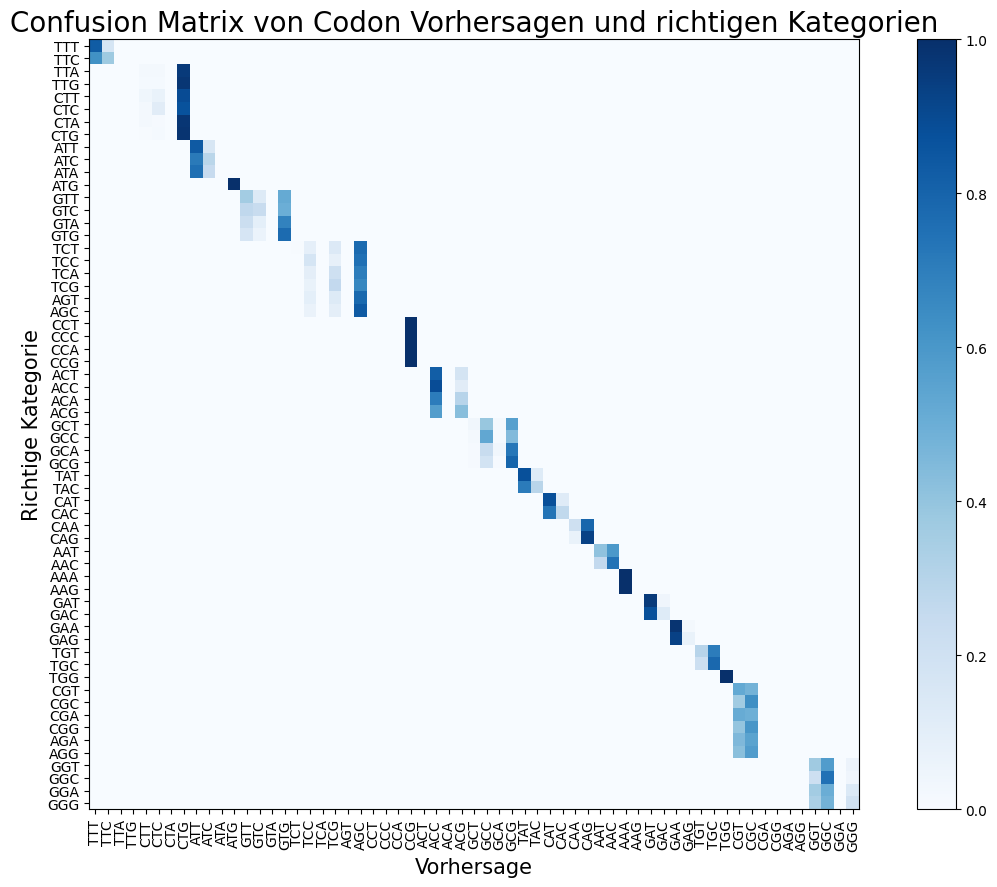

In [51]:
title = 'Confusion Matrix von Codon Vorhersagen und richtigen Kategorien'

codons = [c for c in mlh.codons if c != '___']

plt = mle.plot_confusion_matrix(labels, predicted, mlh.codons_sorted, title, sort_codons=True)
plt.show()

### Aminosäuren Accuracy

$$A\_Acc = \frac{T\_a}{G\_a} $$

- $T\_a$: Anzahl der richtig klassifizierten ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus
- $G\_a$: Gesamtanzahl der ausgewählten Aminosäure über alle Testsequenzen eines betrachteten Organismus

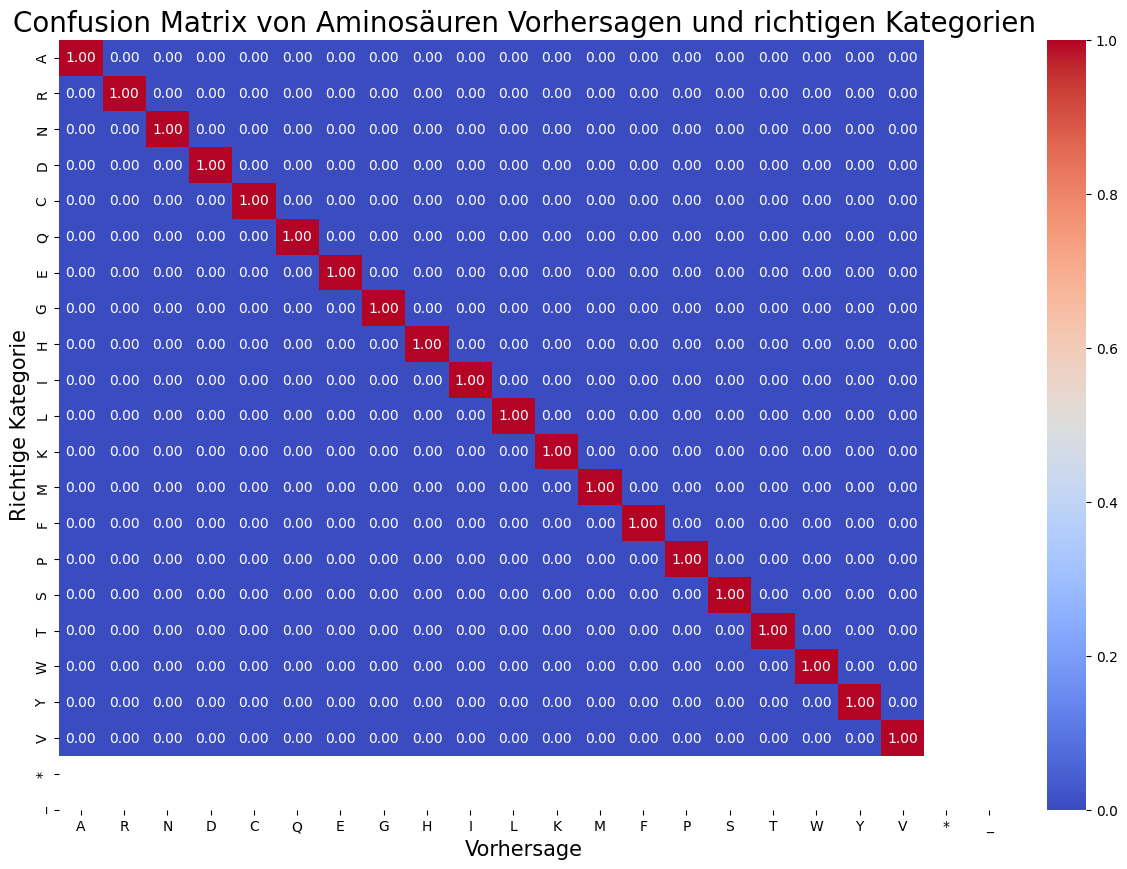

In [52]:
# Calculate confusion matrix for amino acids

plt = mle.plot_confusion_matrix_sns(labels_aa, predicted_aa, mlh.amino_acids, 
                                        'Confusion Matrix von Aminosäuren Vorhersagen und richtigen Kategorien')
plt.show()

{'ATG': 3365, 'CGA': 0, 'CAT': 1380, 'CCT': 0, 'TTA': 0, 'GTG': 2371, 'GGT': 1131, 'AAC': 2006, 'TGG': 1761, 'AAA': 4148, 'CTG': 6282, 'GGC': 2625, 'AGC': 1585, 'CGC': 1566, 'CAC': 299, 'GTT': 796, 'GAG': 148, 'TCT': 5, 'CGT': 1339, 'GCA': 80, 'GCT': 62, 'TGT': 164, 'GCG': 3153, 'ATC': 862, 'CCA': 0, 'CCG': 2775, 'GAA': 4652, 'TAT': 1656, 'GAT': 3679, 'AAG': 0, 'CAA': 387, 'GAC': 282, 'TCC': 181, 'TTC': 769, 'ACC': 2554, 'CAG': 3259, 'TAC': 418, 'ACT': 0, 'TGC': 588, 'AAT': 848, 'GTA': 0, 'ATT': 3041, 'TTT': 2175, 'GCC': 1619, 'TTG': 0, 'CTT': 45, 'ATA': 0, 'AGA': 0, 'GTC': 418, 'AGT': 0, 'ACG': 686, 'CGG': 0, 'TCA': 0, 'CTA': 0, 'CTC': 134, 'ACA': 0, 'AGG': 0, 'GGA': 0, 'TCG': 280, 'CCC': 0, 'GGG': 235}


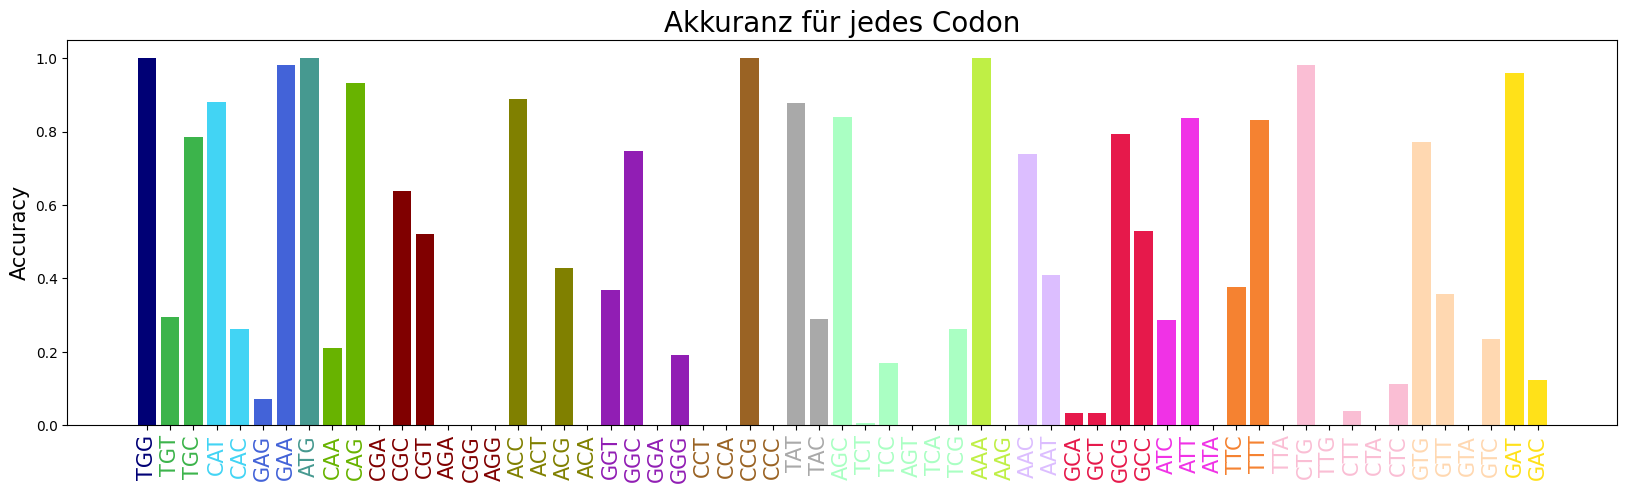

In [53]:
plt = mle.plot_codon_acc(labels, predicted, 'Akkuranz für jedes Codon')

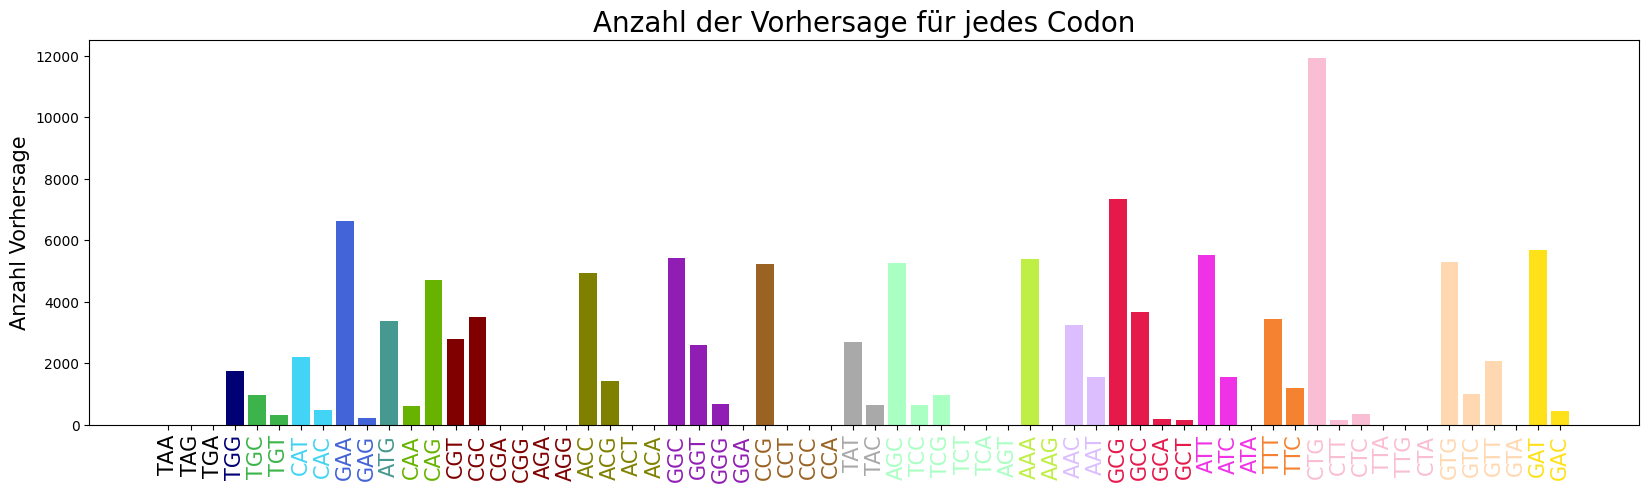

In [54]:
codon_counted_predicted = mle.codon_count(predicted)

plt = mle.plot_codon_count(codon_counted_predicted, 'Anzahl der Vorhersage für jedes Codon')

### Durchschnittliche Codon Accuracy

$$Avg\_CACC = \frac{\sum_{sc \in SC} c\_acc\{sc\}}{|SC|} $$

- $c\_acc$: Codon Accuracy
- $SC$: Synonyme Codons für die ausgewählte Aminosäure über alle Testsequenzen eines betrachteten Organismus

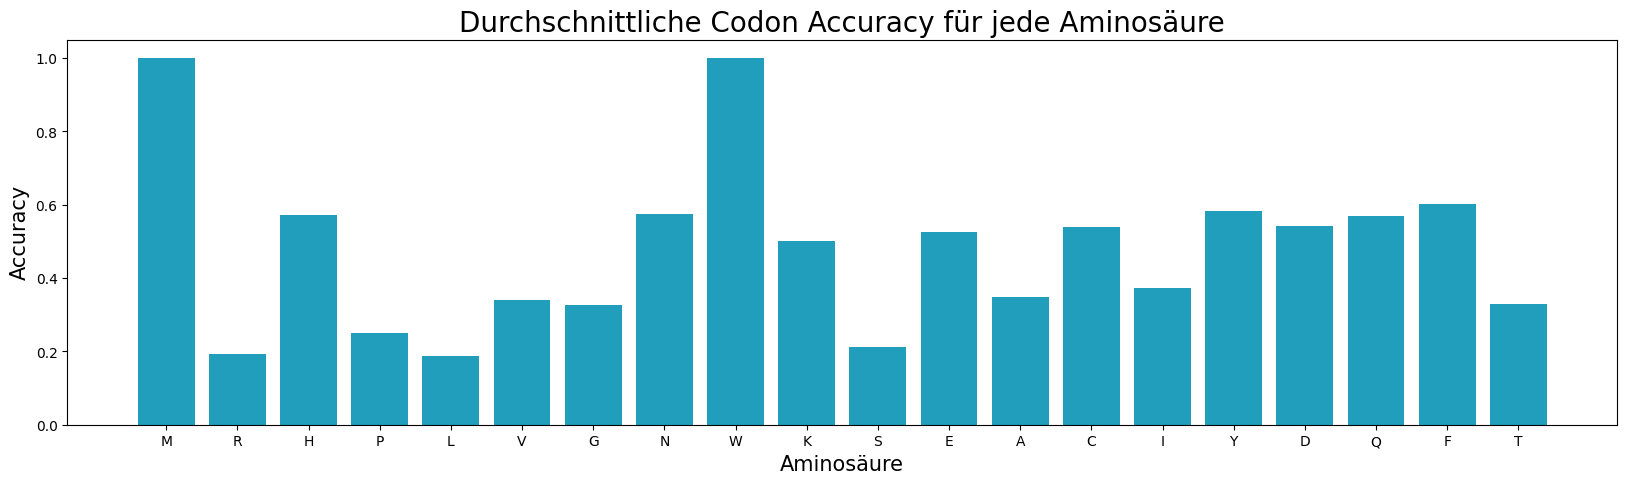

In [55]:

plt = mle.plot_avg_aa_acc(labels, predicted)
plt.show()

In [56]:
"""
pad_int = mlh.codons.index('___')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for (org, segment_size) in [("E.Coli", 10), ("Drosophila.Melanogaster", 10), ("Homo.Sapiens", 10)]:
    test_dataset = mlh.CodonDataset(organism=org, split="test", padding_pos=None, data_path='../data/', one_hot_aa=False)
    test_loader = DataLoader(test_dataset, batch_size=1)
    print(f"Datensatz geladen für {org}")

    # test all models and save the best one for further evaluation
    tcnn_Model = mlh.load_model("tcn", org, device=device, path_model_dir="../ml_models")

    #classifier = rnn.RNN_Classifier(rnnModel)
    classifier = tcnn.Tcn_Classifier(tcnn_Model)
    preds = classifier.predict_codons(test_loader)

    predictions = []
    for pred in preds:
        pred_new = [int(p) if p != '___' and p != '' else int(pad_int) for p in pred]
        predictions.append(pred_new)
    

    labels = []
    for seq, lab in test_dataset:
        # lab = seq_lab[1]
        #print(lab)s
        #lab = [str(mlh.integer_to_codons[c.item()]) for c in lab]
        lab = [int(c.item()) for c in lab]
        labels.append(lab)

    for i, (lab, pred) in enumerate(zip(labels, predictions)):
        if len(lab) != len(pred):
            print(f"Mismatch at index {i}: labels length {len(lab)}, predictions length {len(pred)}")
    
    # labels = test_dataset[:][1]
    seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, predictions, segment_size=segment_size)

    #seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, predictions, segment_size=segment_size, cut_off=0.25)
    mle.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nTCNN Modell und Daten für {org}")
"""

'\npad_int = mlh.codons.index(\'___\')\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nfor (org, segment_size) in [("E.Coli", 10), ("Drosophila.Melanogaster", 10), ("Homo.Sapiens", 10)]:\n    test_dataset = mlh.CodonDataset(organism=org, split="test", padding_pos=None, data_path=\'../data/\', one_hot_aa=False)\n    test_loader = DataLoader(test_dataset, batch_size=1)\n    print(f"Datensatz geladen für {org}")\n\n    # test all models and save the best one for further evaluation\n    tcnn_Model = mlh.load_model("tcn", org, device=device, path_model_dir="../ml_models")\n\n    #classifier = rnn.RNN_Classifier(rnnModel)\n    classifier = tcnn.Tcn_Classifier(tcnn_Model)\n    preds = classifier.predict_codons(test_loader)\n\n    predictions = []\n    for pred in preds:\n        pred_new = [int(p) if p != \'___\' and p != \'\' else int(pad_int) for p in pred]\n        predictions.append(pred_new)\n    \n\n    labels = []\n    for seq, lab in test_dataset:\n        # la

In [57]:
"""
pad_int = mlh.codons.index('___')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for (org, segment_size) in [("E.Coli", 10), ("Drosophila.Melanogaster", 10), ("Homo.Sapiens", 10)]:
    test_dataset = mlh.CodonDataset(organism=org, split="test", padding_pos=None, data_path='../data/', one_hot_aa=False)
    test_loader = DataLoader(test_dataset, batch_size=1)
    print(f"Datensatz geladen für {org}")

    # test all models and save the best one for further evaluation
    tcnn_Model = mlh.load_model("tcn", org, device=device, path_model_dir="../ml_models")

    #classifier = rnn.RNN_Classifier(rnnModel)
    classifier = tcnn.Tcn_Classifier(tcnn_Model)
    preds = classifier.predict_codons(test_loader)

    predictions = []
    for pred in preds:
        pred_new = [int(p) if p != '___' and p != '' else int(pad_int) for p in pred]
        predictions.append(pred_new)
    

    labels = []
    for seq, lab in test_dataset:
        # lab = seq_lab[1]
        #print(lab)s
        #lab = [str(mlh.integer_to_codons[c.item()]) for c in lab]
        lab = [int(c.item()) for c in lab]
        labels.append(lab)

    for i, (lab, pred) in enumerate(zip(labels, predictions)):
        if len(lab) != len(pred):
            print(f"Mismatch at index {i}: labels length {len(lab)}, predictions length {len(pred)}")
    
    # labels = test_dataset[:][1]
    seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, predictions, segment_size=segment_size, cut_data_at=0.2)

    #seg_acc, seg_el = classifier.calc_accuracy_per_segment(labels, predictions, segment_size=segment_size, cut_off=0.25)
    ml_evaluation.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nTCNN Modell und Daten für {org}")
"""

'\npad_int = mlh.codons.index(\'___\')\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nfor (org, segment_size) in [("E.Coli", 10), ("Drosophila.Melanogaster", 10), ("Homo.Sapiens", 10)]:\n    test_dataset = mlh.CodonDataset(organism=org, split="test", padding_pos=None, data_path=\'../data/\', one_hot_aa=False)\n    test_loader = DataLoader(test_dataset, batch_size=1)\n    print(f"Datensatz geladen für {org}")\n\n    # test all models and save the best one for further evaluation\n    tcnn_Model = mlh.load_model("tcn", org, device=device, path_model_dir="../ml_models")\n\n    #classifier = rnn.RNN_Classifier(rnnModel)\n    classifier = tcnn.Tcn_Classifier(tcnn_Model)\n    preds = classifier.predict_codons(test_loader)\n\n    predictions = []\n    for pred in preds:\n        pred_new = [int(p) if p != \'___\' and p != \'\' else int(pad_int) for p in pred]\n        predictions.append(pred_new)\n    \n\n    labels = []\n    for seq, lab in test_dataset:\n        # la

In [58]:
predicted_int = predicted.copy()
labels_int = labels.copy()

In [59]:
predicted = np.array([mlh.codons[p] for p in predicted_int])
labels = np.array([mlh.codons[int(p)] for p in labels_int])

pn_dict = mle.create_pn_dict(predicted, labels, organism)
print(pn_dict)

{'TTT': {'num': 2616, 'P_M==B': 0.8314220183486031, 'P_M!=B': 0, 'N_M==B': 0, 'N_M!=B': 0.16857798165137536}, 'TTC': {'num': 2051, 'P_M==B': 0, 'P_M!=B': 0.37493905411993667, 'N_M==B': 0.6250609458800411, 'N_M!=B': 0}, 'TTA': {'num': 1643, 'P_M==B': 0, 'P_M!=B': 0, 'N_M==B': 0.9604382227632631, 'N_M!=B': 0.03956177723676201}, 'TTG': {'num': 1551, 'P_M==B': 0, 'P_M!=B': 0, 'N_M==B': 0.9729206963249867, 'N_M!=B': 0.02707930367504834}, 'CTT': {'num': 1222, 'P_M==B': 0, 'P_M!=B': 0.03682487725040918, 'N_M==B': 0.8944353518821763, 'N_M!=B': 0.06873977086743038}, 'CTC': {'num': 1204, 'P_M==B': 0, 'P_M!=B': 0.11129568106312317, 'N_M==B': 0.8687707641196104, 'N_M!=B': 0.019933554817275743}, 'CTA': {'num': 423, 'P_M==B': 0, 'P_M!=B': 0, 'N_M==B': 0.9739952718676136, 'N_M!=B': 0.026004728132387706}, 'CTG': {'num': 6404, 'P_M==B': 0.9809494066206975, 'P_M!=B': 0, 'N_M==B': 0, 'N_M!=B': 0.019050593379138038}, 'ATT': {'num': 3637, 'P_M==B': 0.836128677481465, 'P_M!=B': 0, 'N_M==B': 0, 'N_M!=B': 0.1

In [60]:
cub_test_data = {}

for codon in pn_dict:
    aa = mlh.codon_to_amino_acid[codon]
    aa_codons = mlh.amino_acids_to_codons.get(aa, [])
    aa_sum = sum(pn_dict[c]['num'] for c in aa_codons)
    cub_test_data[codon] = pn_dict[codon]['num'] / aa_sum

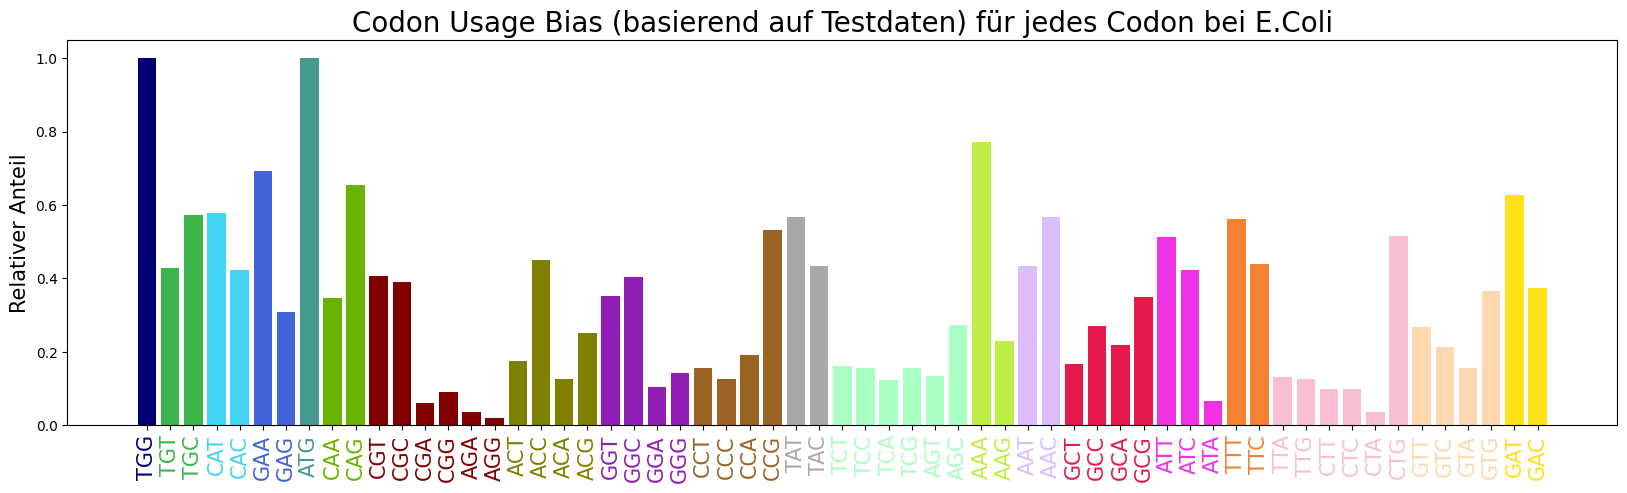

In [61]:
_, keys = mle.plot_cub(cub_test_data, f"Codon Usage Bias (basierend auf Testdaten) für jedes Codon bei {organism}")

In [62]:
pn_dict = { codon : pn_dict[codon] for codon in keys if codon in pn_dict}

<module 'matplotlib.pyplot' from 'c:\\Users\\felix\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

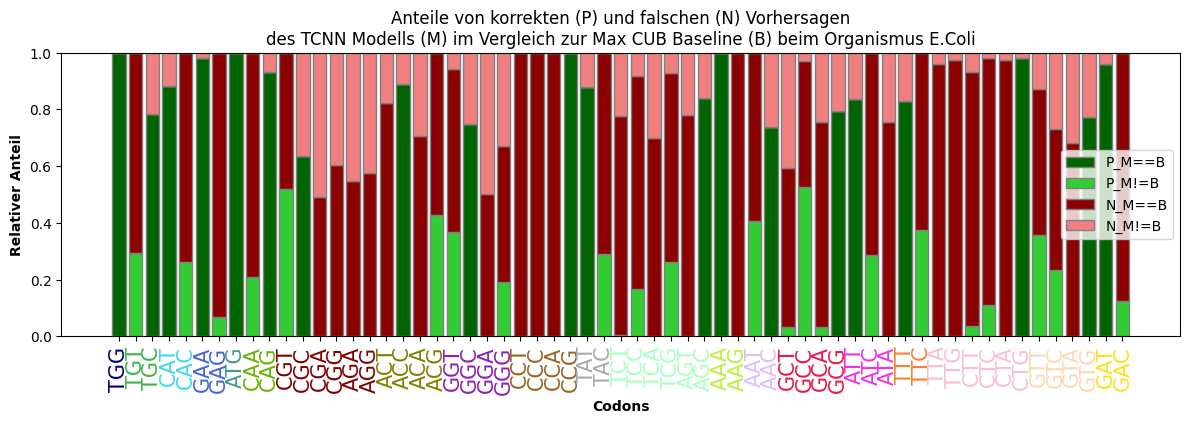

In [63]:
mle.plot_pn_dict(pn_dict, 'TCNN', organism)